In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pytorch_lightning as pl


In [3]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [4]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])




In [5]:
train_dataset = torchvision.datasets.DatasetFolder(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/04-Pneumonia-Classification/04-Pneumonia-Classification/Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/04-Pneumonia-Classification/04-Pneumonia-Classification/Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)



C:\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


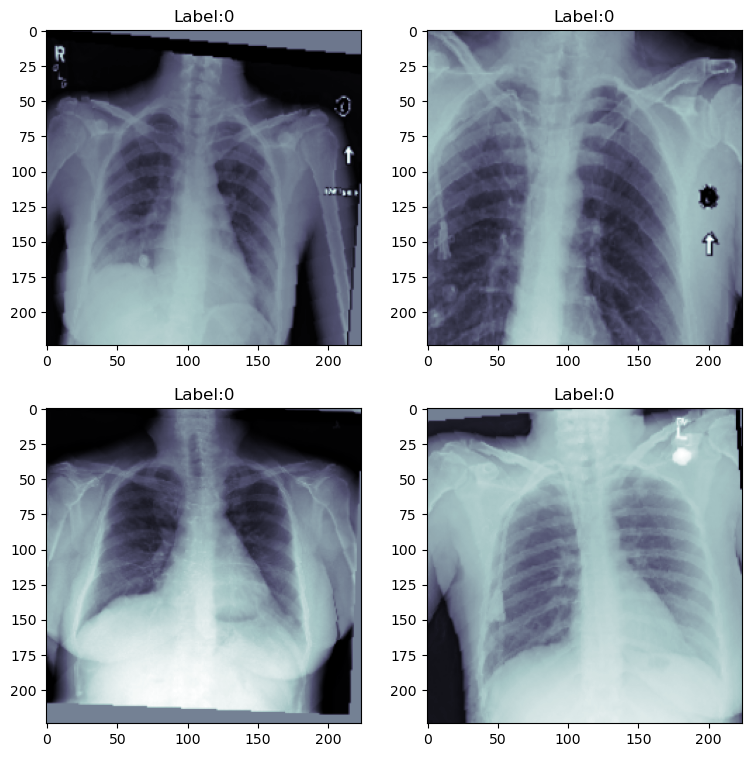

In [6]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")



In [7]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")


# The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
# There are multiple ways to deal with imbalanced datasets:

    #Weighted Loss
    #Oversampling
    #Doing nothing :)

#In this example, we will simply do nothing as this often yields the best results. 
# Buf feel free to play around with a weighted loss. A template to define a customized weighted loss function is provided below.

#Oversampling will be shown in a later lecture.


There are 24000 train images and 2684 val images


In [8]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407], dtype=int64)),
 (array([0, 1]), array([2079,  605], dtype=int64)))

In [9]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:, 0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_train_epoch_end(self) -> None:
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)

        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_validation_epoch_end(self) -> None:
        self.log("Val Acc", self.val_acc.compute())


    def configure_optimizers(self):
        # Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [10]:
model = PneumoniaModel()  # Instanciate the model

In [11]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

In [12]:
trainer = pl.Trainer(accelerator='gpu', max_epochs=35)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
gpus = 1
trainer = pl.Trainer(
    devices=gpus,  
    logger=TensorBoardLogger("C:/Users/Owner/Downloads/Udemy/Pytorch/04-Pneumonia-Classification/04-Pneumonia-Classification/logs"),
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=20 # Increase this number to increase the accuracy, but this will take longer(depens on computer)
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Anaconda\envs\pytorch\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Anaconda\envs\pytorch\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

C:\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/04-Pneumonia-Classification/04-Pneumonia-Classification/weights/weights_1.ckpt")
model.eval()
model.to(device);

C:\Anaconda\envs\pytorch\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:201: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.0.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\Owner\Downloads\Udemy\Pytorch\04-Pneumonia-Classification\04-Pneumonia-Classification\weights\weights_1.ckpt`


In [18]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

In [22]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='multiclass',num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='multiclass',num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")


#
#Val Accuracy: 0.8457: About 84.57% of the predictions made by your model are correct.
#Val Precision: 0.7002: When your model predicts positive, it's correct about 70.02% of the time.
#Val Recall: 0.5521: Of all the actual positive instances, your model correctly identified about 55.21% of them.
#Confusion Matrix:
    #The matrix shows that out of the total predictions:
           # 2079 were correctly predicted as class 0 (True Negative)
           # 0 were wrongly predicted as class 1 (False Positive)
           # 605 were wrongly predicted as class 0 (False Negative)
           # 0 were correctly predicted as class 1 (True Positive)
    #Confusion Matrix 2: Even after applying a threshold of 0.25, the confusion matrix remains the same.

Val Accuracy: 0.8457525968551636
Val Precision: 0.7002096176147461
Val Recall: 0.5520660877227783
Confusion Matrix:
 tensor([[2079,    0],
        [ 605,    0]])
Confusion Matrix 2:
 tensor([[2079,    0],
        [ 605,    0]])


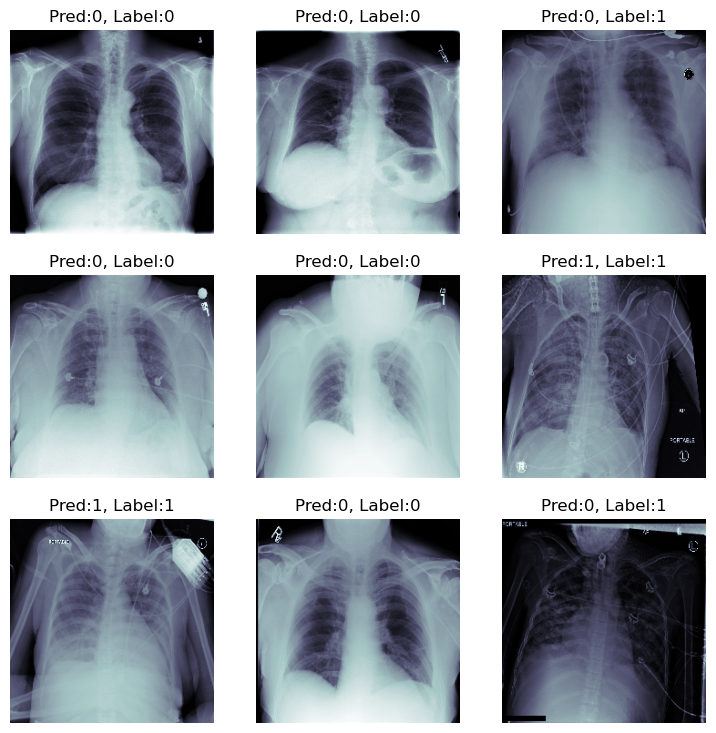

In [23]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")
